# Exploratory Data analysis

About Dataset
Context
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

Content
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents
Inspiration
To explore this type of models and learn more about the subject.

## Imports and settings

Import the libraries we'll use and set some display options for nicer outputs.

In [12]:
! pip install mlxtend lifelines plotly missingno

# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from lifelines import CoxPHFitter, KaplanMeierFitter


[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: C:\Users\areeb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Load dataset

We'll load the Telco Customer Churn CSV that is in the `data/` folder and show shape and the first rows.

In [27]:
import os

csv_path = os.path.join("data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")

df = pd.read_csv(csv_path)

print("Dataset path:", csv_path)
print("Shape:", df.shape)

df.head()

Dataset path: data\WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Quick data inspection

Check dtypes, missing values, basic statistics and unique counts for categorical columns.

In [28]:
print("Info:")
df.info()

print("\nMissing values per column:")
print(df.isna().sum())

print("\nUnique values for object dtypes:")
for col in df.select_dtypes(include="object").columns:
    print(col, ":", df[col].nunique())

print("\nDescribe (numeric):")
print(df.describe())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   ob

## Clean TotalCharges and quick fixes

`TotalCharges` can sometimes be read as object because of spaces/empty strings. Convert to numeric and inspect rows with missing or problematic values.

In [29]:
df_clean = df.copy()

df_clean["TotalCharges"] = df_clean["TotalCharges"].replace(" ", np.nan)
df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

print("Missing TotalCharges after conversion:", df_clean["TotalCharges"].isna().sum())
if df_clean["TotalCharges"].isna().sum() > 0:
    display(df_clean[df_clean["TotalCharges"].isna()].head())

print("\nValue counts of tenure==0 among TotalCharges NA:")
print((df_clean[df_clean["TotalCharges"].isna()]["tenure"] == 0).sum())

df_clean["TotalCharges_filled"] = df_clean["TotalCharges"].fillna(
    df_clean["MonthlyCharges"] * df_clean["tenure"]
)

print("\nDone conversion. Using `df_clean` going forward for EDA.")

Missing TotalCharges after conversion: 11


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No



Value counts of tenure==0 among TotalCharges NA:
11

Done conversion. Using `df_clean` going forward for EDA.


## Churn distribution and numeric variable plots

Explore churn counts and distributions for tenure, MonthlyCharges, and TotalCharges_filled.

Churn
No     5174
Yes    1869
Name: count, dtype: int64


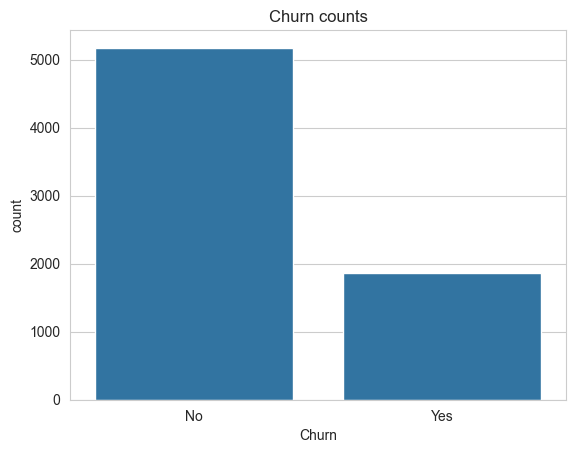

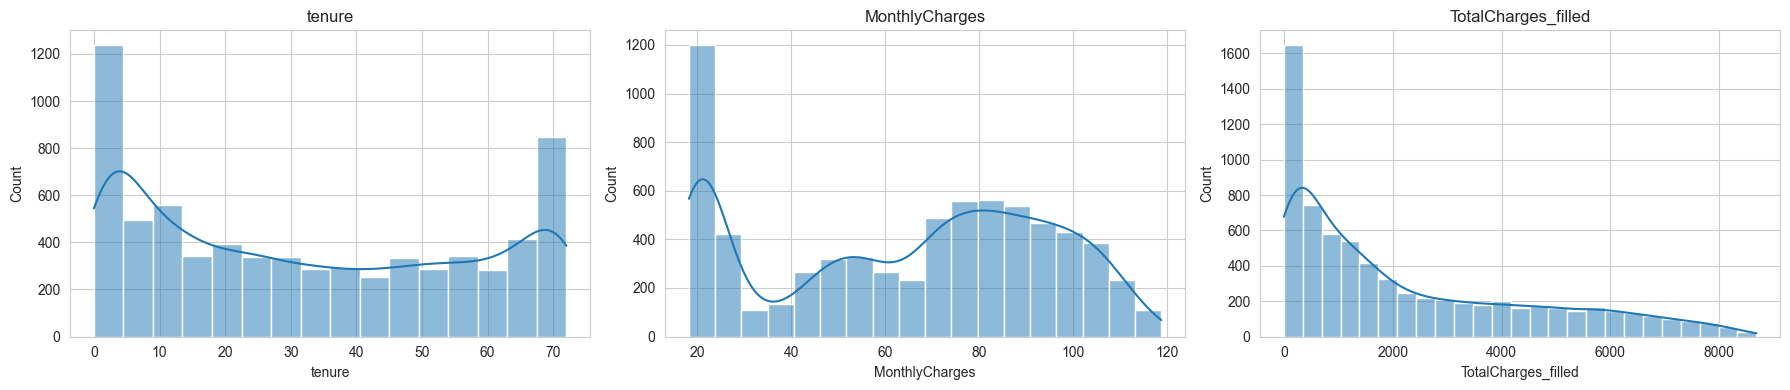

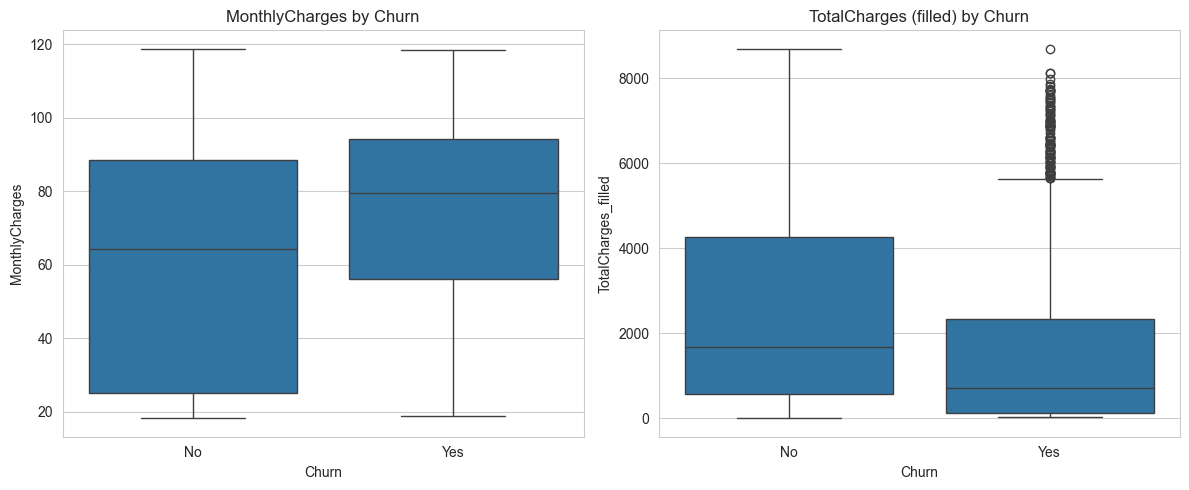

In [30]:
print(df_clean["Churn"].value_counts())
ax = sns.countplot(data=df_clean, x="Churn")
ax.set_title("Churn counts")

numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges_filled"]
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for col, ax in zip(numeric_cols, axes):
    sns.histplot(df_clean[col].dropna(), kde=True, ax=ax)
    ax.set_title(col)
plt.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df_clean, ax=axes[0])
axes[0].set_title("MonthlyCharges by Churn")
sns.boxplot(x="Churn", y="TotalCharges_filled", data=df_clean, ax=axes[1])
axes[1].set_title("TotalCharges (filled) by Churn")
plt.tight_layout()

## Categorical counts (selected columns)

Plot counts for some important categorical variables: `Contract`, `PaymentMethod`, `InternetService`, `gender`, `SeniorCitizen`, `Partner`, `Dependents`.

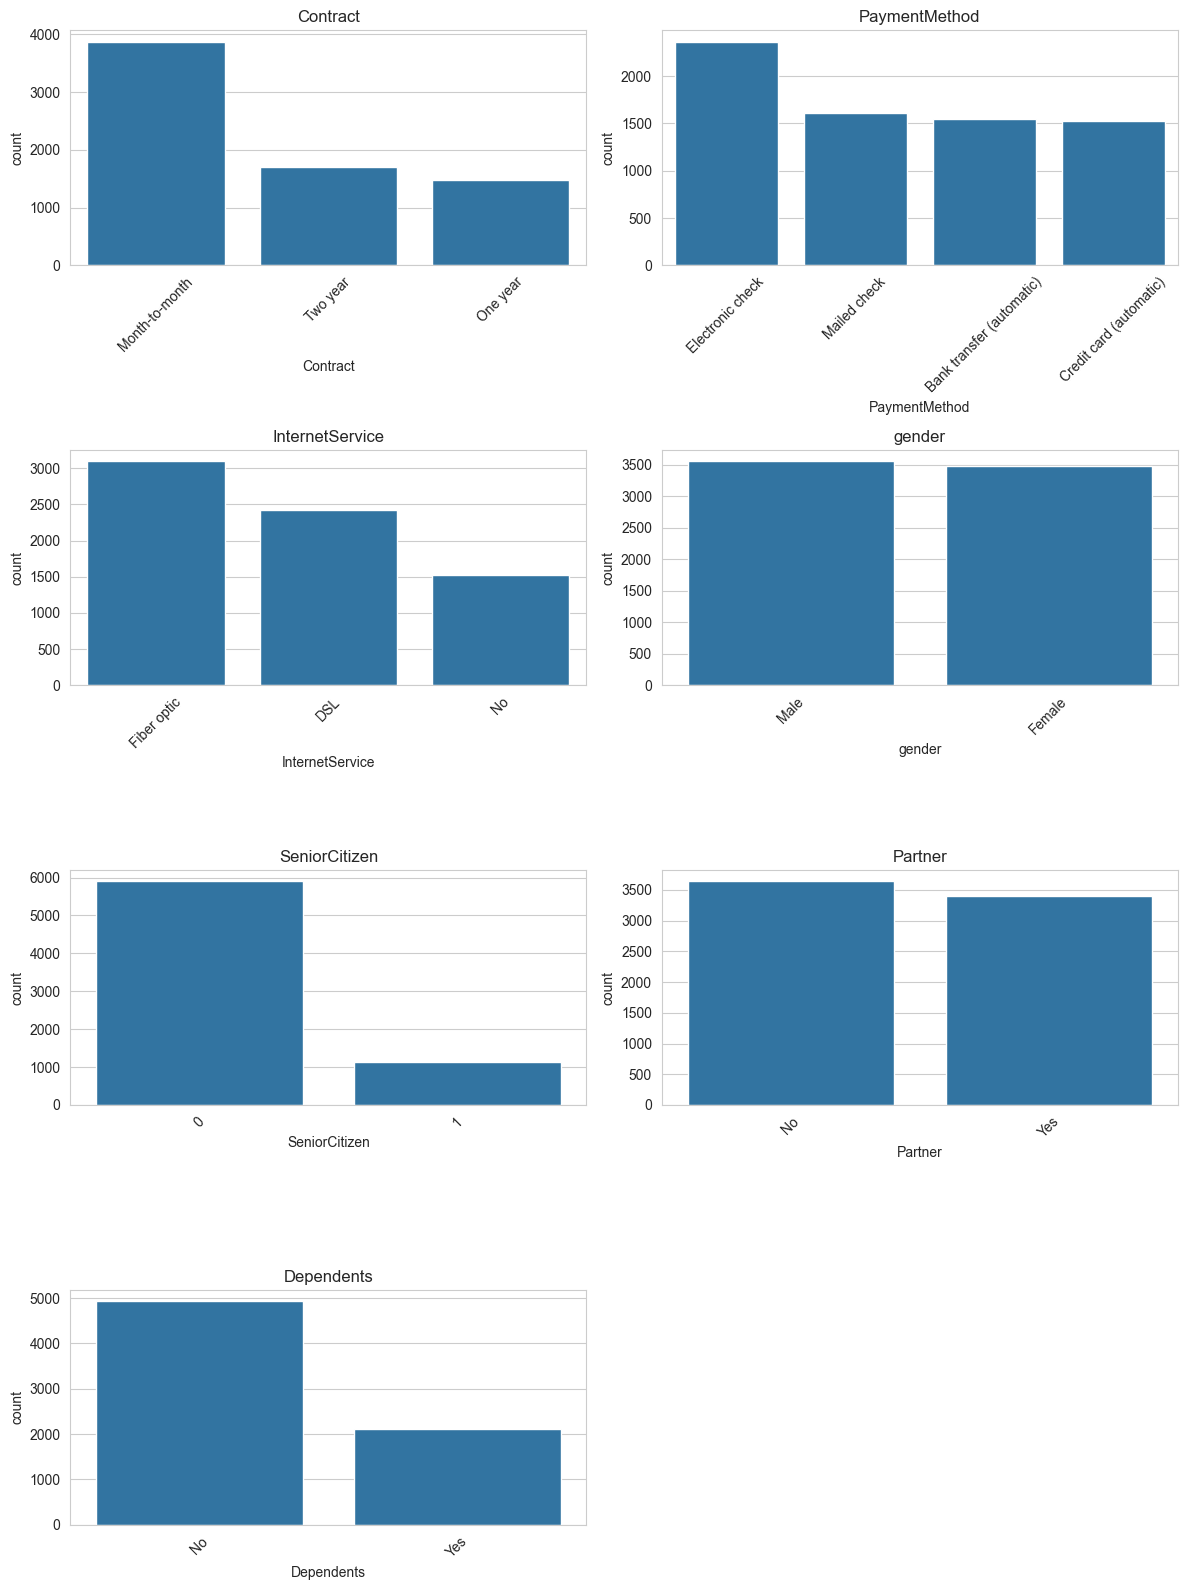

In [31]:
cat_cols = [
    "Contract",
    "PaymentMethod",
    "InternetService",
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
]

ncols = 2
nrows = int(np.ceil(len(cat_cols) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()
for ax, col in zip(axes, cat_cols):
    order = df_clean[col].value_counts().index
    sns.countplot(data=df_clean, x=col, order=order, ax=ax)
    ax.set_title(col)
    ax.tick_params(axis="x", rotation=45)

for ax in axes[len(cat_cols) :]:
    ax.set_visible(False)
plt.tight_layout()

## Correlation heatmap (numeric features)

Show correlations between numeric features (tenure, MonthlyCharges, TotalCharges_filled).

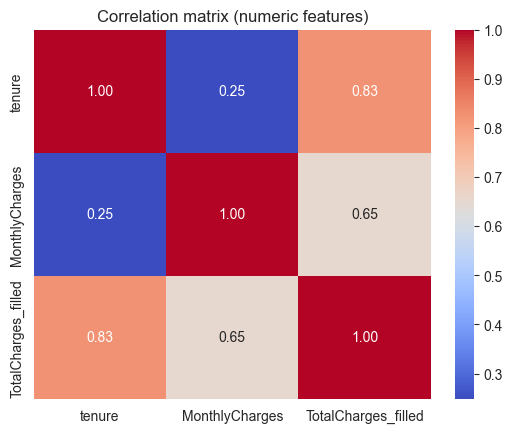

In [32]:
num_for_corr = ["tenure", "MonthlyCharges", "TotalCharges_filled"]
corr = df_clean[num_for_corr].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix (numeric features)")
plt.show()

## Setup and Data Check

In [33]:
sns.set_style("whitegrid")

print("--- Using preloaded DataFrame 'df' ---")
nan_count = df["TotalCharges"].isna().sum()
print(f"Found {nan_count} rows with empty TotalCharges (post earlier preprocessing).")
print(f"Current shape: {df.shape}")

--- Using preloaded DataFrame 'df' ---
Found 0 rows with empty TotalCharges (post earlier preprocessing).
Current shape: (7043, 21)


## Task 1: Clustering (Customer Segmentation)



--- Task 1: Clustering (Customer Segmentation) ---
Running Elbow Method to find optimal k...
Elbow method plot saved as 'elbow_method_plot.png'.


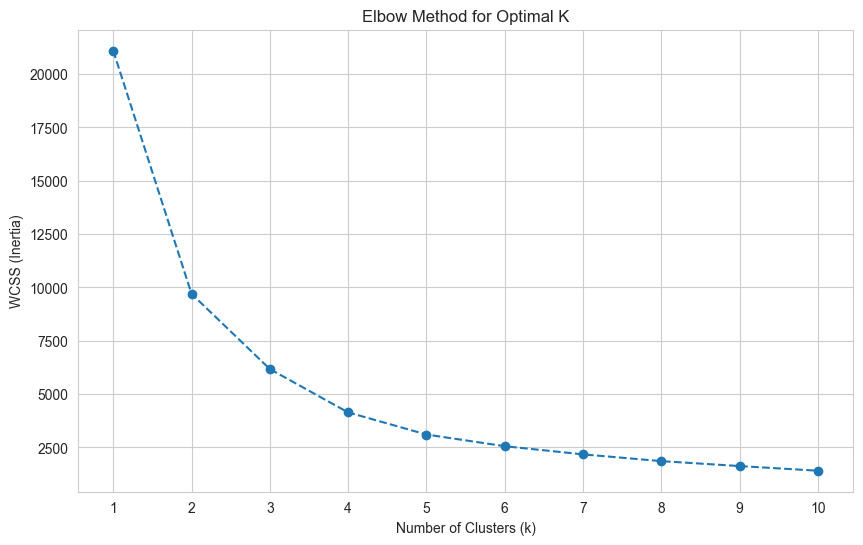

Running KMeans with k=4...

--- Analysis of Segments (Mean values by cluster) ---
            tenure  MonthlyCharges  TotalCharges
Cluster                                         
0        10.277123       31.777771    303.821875
1        59.530987       93.306224   5548.653887
2        53.585850       34.920147   1836.581320
3        15.445227       80.791201   1252.816564

--- Churn Rate by Cluster ---
Churn          No       Yes
Cluster                    
0        0.752358  0.247642
1        0.846113  0.153887
2        0.949957  0.050043
3        0.516938  0.483062
Cluster scatter plot saved as 'customer_segments_scatter.png'.


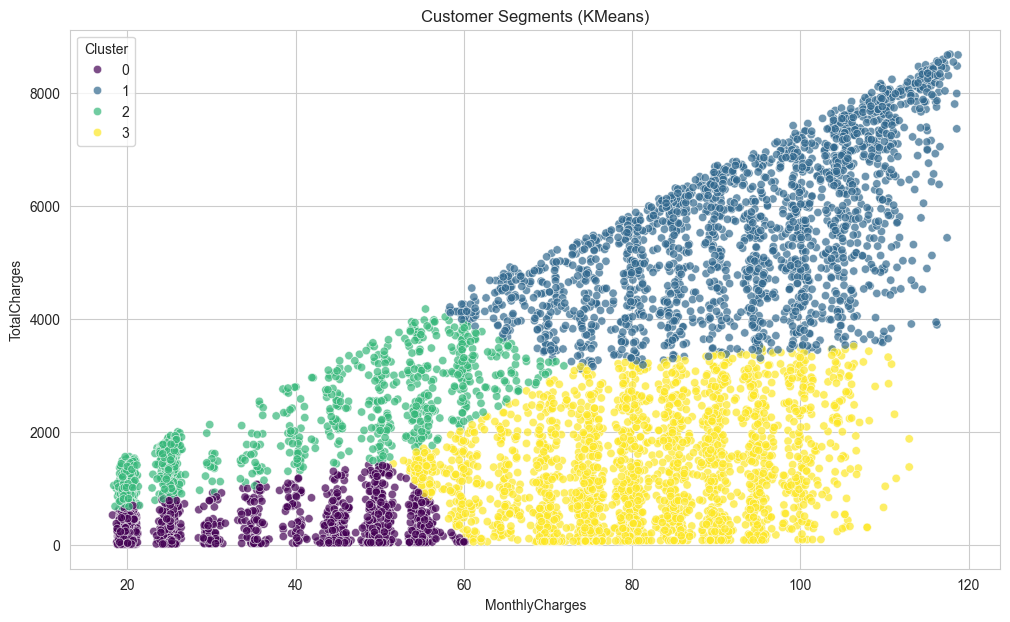


--- Task 1b: Naming Customer Segments ---

Segments sorted by average MonthlyCharges:
   Cluster  MonthlyCharges
0        0       31.777771
2        2       34.920147
3        3       80.791201
1        1       93.306224

Mapping 4 cluster IDs to new names:
{0: 'Low Spenders', 2: 'Medium-Low Spenders', 3: 'Medium-High Spenders', 1: 'High Spenders'}

DataFrame with new 'SegmentName' column added:
   customerID  MonthlyCharges  Cluster           SegmentName
0  7590-VHVEG           29.85        0          Low Spenders
1  5575-GNVDE           56.95        2   Medium-Low Spenders
2  3668-QPYBK           53.85        0          Low Spenders
3  7795-CFOCW           42.30        2   Medium-Low Spenders
4  9237-HQITU           70.70        3  Medium-High Spenders

--- Final Segment Analysis (by Name) ---
                         tenure  MonthlyCharges  TotalCharges
SegmentName                                                  
Low Spenders          10.277123       31.777771    303.821875
Medium

In [37]:
# --- TASK 1: CLUSTERING (Customer Segmentation) ---
import warnings

warnings.filterwarnings("ignore")

print("\n\n--- Task 1: Clustering (Customer Segmentation) ---")

# --- 1. Data Preparation ---
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(inplace=True)

features = ["tenure", "MonthlyCharges", "TotalCharges"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 2. Elbow Method to Find Optimal K ---
print("Running Elbow Method to find optimal k...")
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker="o", linestyle="--")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Inertia)")
plt.xticks(k_range)
plt.grid(True)
plt.savefig("elbow_method_plot.png")
print("Elbow method plot saved as 'elbow_method_plot.png'.")
plt.show()

# --- 3. Final KMeans Clustering ---
optimal_k = 4  # change if needed based on elbow plot
print(f"Running KMeans with k={optimal_k}...")

kmeans_final = KMeans(
    n_clusters=optimal_k, init="k-means++", n_init=10, random_state=42
)
clusters = kmeans_final.fit_predict(X_scaled)
df["Cluster"] = clusters

# --- 4. Cluster Analysis ---
print("\n--- Analysis of Segments (Mean values by cluster) ---")
print(df.groupby("Cluster")[features].mean())

if "Churn" in df.columns:
    print("\n--- Churn Rate by Cluster ---")
    print(df.groupby("Cluster")["Churn"].value_counts(normalize=True).unstack())

# --- 5. Visualization ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df,
    x="MonthlyCharges",
    y="TotalCharges",
    hue="Cluster",
    palette="viridis",
    alpha=0.7,
)
plt.title("Customer Segments (KMeans)")
plt.savefig("customer_segments_scatter.png")
print("Cluster scatter plot saved as 'customer_segments_scatter.png'.")
plt.show()

# --- 6. Naming Customer Segments (Task 1b) ---
print("\n--- Task 1b: Naming Customer Segments ---")

cluster_features = ["tenure", "MonthlyCharges", "TotalCharges"]

try:
    # Sort clusters by spending level
    segment_analysis_means = (
        df.groupby("Cluster")["MonthlyCharges"].mean().reset_index()
    )
    sorted_segments = segment_analysis_means.sort_values(
        by="MonthlyCharges", ascending=True
    )

    print("\nSegments sorted by average MonthlyCharges:")
    print(sorted_segments)

    k = df["Cluster"].nunique()

    if k == 3:
        segment_names = ["Low Spenders", "Medium Spenders", "High Spenders"]
    elif k == 4:
        segment_names = [
            "Low Spenders",
            "Medium-Low Spenders",
            "Medium-High Spenders",
            "High Spenders",
        ]
    elif k == 5:
        segment_names = [
            "Lowest Spenders",
            "Low Spenders",
            "Medium Spenders",
            "High Spenders",
            "Highest Spenders",
        ]
    else:
        segment_names = [f"Segment {i+1} (Low-to-High)" for i in range(k)]

    mapping = dict(zip(sorted_segments["Cluster"], segment_names))

    print(f"\nMapping {k} cluster IDs to new names:")
    print(mapping)

    df["SegmentName"] = df["Cluster"].map(mapping)

    print("\nDataFrame with new 'SegmentName' column added:")
    print(df[["customerID", "MonthlyCharges", "Cluster", "SegmentName"]].head())

    print("\n--- Final Segment Analysis (by Name) ---")
    final_analysis = df.groupby("SegmentName")[cluster_features].mean()
    print(final_analysis.sort_values(by="MonthlyCharges"))

except NameError as e:
    print(f"\nError: {e}")
    print("Please make sure you have run the main code block first.")
    print("This code requires the 'df' DataFrame with the 'Cluster' column.")
except KeyError as e:
    print(f"\nError: {e}")
    print("It looks like the 'Cluster' column does not exist in the 'df' DataFrame.")
    print("Please run the main code block (Task 1) first to create the clusters.")

##  Task 2: Classification (Churn Prediction)



--- Task 2: Classification (Churn Prediction) ---

Data shape after processing for classification: (7032, 34)

Data split and scaled for classification.
Training Random Forest Classifier...
Evaluating model...

Model Accuracy: 78.68%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.70      1407
weighted avg       0.77      0.79      0.78      1407

Plotting feature importances...
Feature importance plot saved as 'churn_feature_importance.png'.


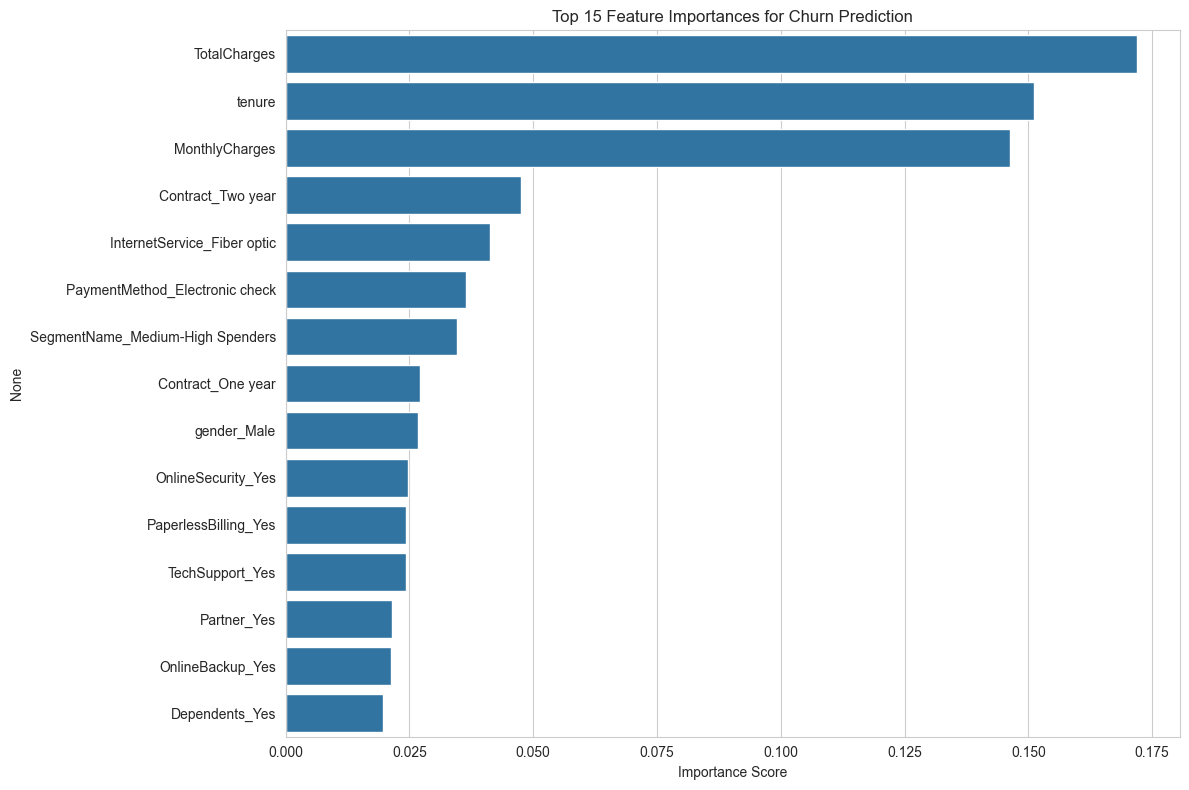

In [38]:
# --- CLASSIFICATION ---
print("\n\n--- Task 2: Classification (Churn Prediction) ---")

df_class = df.drop(["customerID", "Cluster"], axis=1, errors="ignore").copy()

target = "Churn"
if target not in df_class.columns:
    raise KeyError(
        "Column 'Churn' not found in df. Please ensure it exists before Task 2."
    )

# Identify categorical columns (excluding target)
categorical_cols = df_class.select_dtypes(include=["object", "category"]).columns
if target in categorical_cols:
    categorical_cols = categorical_cols.drop(target)

# One-hot encode categoricals (drop_first to avoid dummy trap)
df_class_processed = pd.get_dummies(df_class, columns=categorical_cols, drop_first=True)

# Map Churn to binary if it's not already numeric
if df_class_processed["Churn"].dtype == "O":
    df_class_processed["Churn"] = df_class_processed["Churn"].map({"Yes": 1, "No": 0})

# If it's still not numeric for any reason, coerce
if not pd.api.types.is_numeric_dtype(df_class_processed["Churn"]):
    df_class_processed["Churn"] = pd.to_numeric(
        df_class_processed["Churn"], errors="coerce"
    )

df_class_processed = df_class_processed.dropna(subset=["Churn"])
df_class_processed["Churn"] = df_class_processed["Churn"].astype(int)

print(f"\nData shape after processing for classification: {df_class_processed.shape}")

y = df_class_processed["Churn"]
X = df_class_processed.drop("Churn", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

num_features_class = [
    c for c in ["tenure", "MonthlyCharges", "TotalCharges"] if c in X_train.columns
]
scaler_class = StandardScaler()
if num_features_class:
    X_train[num_features_class] = scaler_class.fit_transform(
        X_train[num_features_class]
    )
    X_test[num_features_class] = scaler_class.transform(X_test[num_features_class])

print("\nData split and scaled for classification.")

# Train model
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)
rf_model.fit(X_train, y_train)

print("Evaluating model...")
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance plot
print("Plotting feature importances...")
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

plt.figure(figsize=(12, 8))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title("Top 15 Feature Importances for Churn Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("churn_feature_importance.png")
print("Feature importance plot saved as 'churn_feature_importance.png'.")
plt.show()

## Task 3: Association Rule Mining (Market Basket Analysis)

In [39]:
# --- ASSOCIATION RULE MINING ---
print("\n\n--- Task 3: Association Rule Mining (Apriori) ---")

# Columns we expect
service_cols = [
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
]

# Ensure required columns exist
missing = [c for c in service_cols if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns for Task 3: {missing}")

df_market = df[service_cols].copy()


def yes(x):  # helper to map Yes/No-like fields with 'No ... service' variants
    return x == "Yes"


no_internet = {"No internet service", "No Internet service", "No internet Service"}
no_phone = {"No phone service", "No Phone service"}

df_basket = pd.DataFrame(index=df_market.index)

# Phone / Lines
df_basket["PhoneService"] = df_market["PhoneService"].apply(lambda v: v == "Yes")
df_basket["MultipleLines"] = df_market["MultipleLines"].apply(lambda v: v == "Yes")

# Internet types
df_basket["Internet_DSL"] = df_market["InternetService"].apply(lambda v: v == "DSL")
df_basket["Internet_Fiber"] = df_market["InternetService"].apply(
    lambda v: v == "Fiber optic"
)

# Internet-dependent add-ons (treat any 'No internet service' as False)
df_basket["OnlineSecurity"] = df_market["OnlineSecurity"].apply(lambda v: v == "Yes")
df_basket["OnlineBackup"] = df_market["OnlineBackup"].apply(lambda v: v == "Yes")
df_basket["DeviceProtection"] = df_market["DeviceProtection"].apply(
    lambda v: v == "Yes"
)
df_basket["TechSupport"] = df_market["TechSupport"].apply(lambda v: v == "Yes")
df_basket["StreamingTV"] = df_market["StreamingTV"].apply(lambda v: v == "Yes")
df_basket["StreamingMovies"] = df_market["StreamingMovies"].apply(lambda v: v == "Yes")

# Force booleans for any stray values
df_basket = df_basket.fillna(False).astype(bool)

print("\nBasket data prepared:")
print(df_basket.head())

# --- Apriori ---
print("\nRunning Apriori to find frequent itemsets (min_support=0.2)...")
frequent_itemsets = apriori(df_basket, min_support=0.2, use_colnames=True)
print("Frequent Itemsets found (top by support):")
print(frequent_itemsets.sort_values(by="support", ascending=False).head())

# --- Association Rules ---
print("\nGenerating association rules (min_confidence=0.7)...")
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

if rules.empty:
    print("\nNo rules found with min_confidence=0.7.")
    print("Try lowering 'min_threshold' for confidence or 'min_support'.")
else:
    rules = rules.sort_values(by="lift", ascending=False)
    print("\n--- Top Association Rules (Sorted by Lift) ---")
    display_cols = ["antecedents", "consequents", "support", "confidence", "lift"]
    print(rules[display_cols].head(10))

print("\n\n--- Analysis Complete ---")



--- Task 3: Association Rule Mining (Apriori) ---

Basket data prepared:
   PhoneService  MultipleLines  Internet_DSL  Internet_Fiber  OnlineSecurity  \
0         False          False          True           False           False   
1          True          False          True           False            True   
2          True          False          True           False            True   
3         False          False          True           False            True   
4          True          False         False            True           False   

   OnlineBackup  DeviceProtection  TechSupport  StreamingTV  StreamingMovies  
0          True             False        False        False            False  
1         False              True        False        False            False  
2          True             False        False        False            False  
3         False              True         True        False            False  
4         False             False        False   

# HAS TO BE CHECKED

# from course 

### Week 4 - "Supplier Selection as a Classification Problem"
I4.0 Concept: Classifying which supplier to choose.

Telco Analogy: Classifying which customer will churn (leave). This is the most important classification problem for a Telco. We will build a Random Forest model to predict "Churn" (Yes/No).

--- Week 4: Classification (Churn Prediction) ---
Data shape for classification: (7032, 35)
Data split and scaled.
Training Random Forest Classifier...
Evaluating model...

Model Accuracy: 79.10%

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

Plotting feature importances...


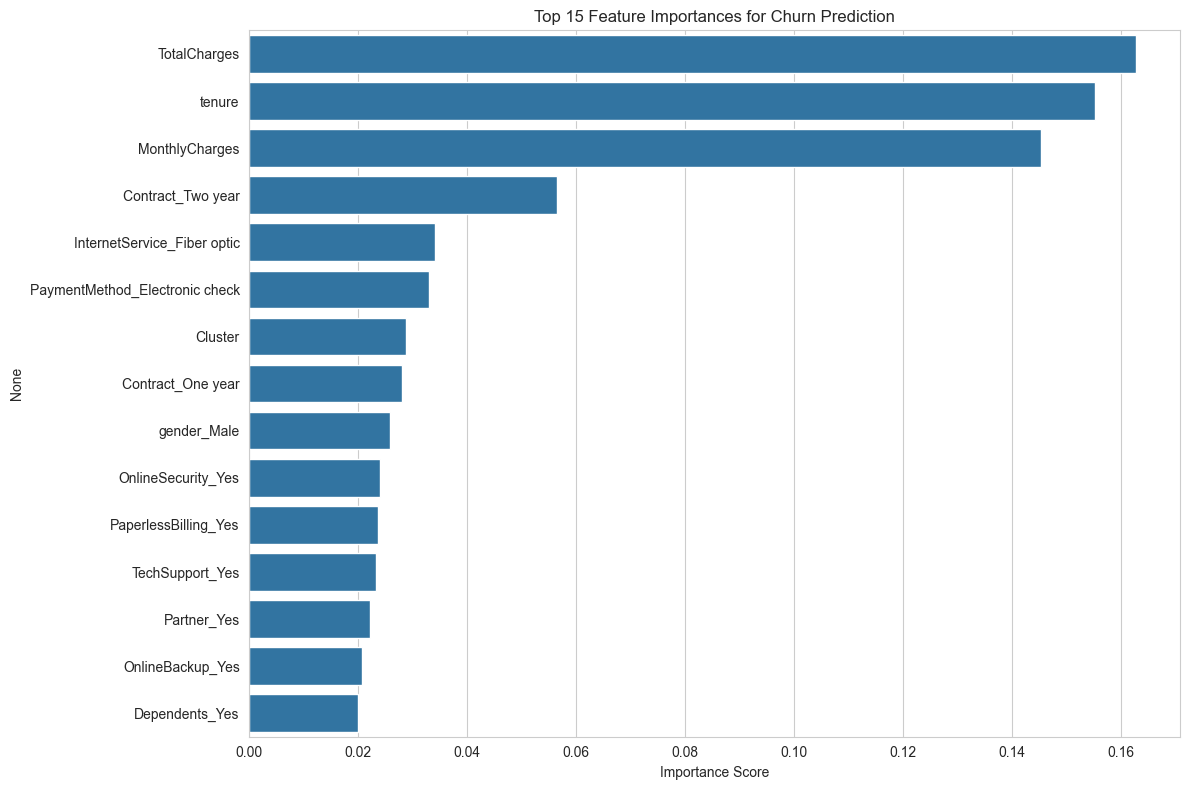

In [ ]:
# --- Week 4: Classification (Predicting Churn) ---
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

print("--- Week 4: Classification (Churn Prediction) ---")

try:
    if "df" not in locals() or "TotalCharges" not in df.columns:
        print("Loading and preprocessing data...")
        df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
        df.dropna(subset=["TotalCharges"], inplace=True)
except NameError:
    print("Error: 'df' not found. Please run your initial data loading cell first.")
    df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    df.dropna(subset=["TotalCharges"], inplace=True)


df_class = df.drop(["customerID"], axis=1, errors="ignore")

categorical_cols = df_class.select_dtypes(include=["object", "category"]).columns
target = "Churn"
categorical_cols = categorical_cols.drop(target)

df_class_processed = pd.get_dummies(df_class, columns=categorical_cols, drop_first=True)

df_class_processed["Churn"] = df_class_processed["Churn"].apply(
    lambda x: 1 if x == "Yes" else 0
)

print(f"Data shape for classification: {df_class_processed.shape}")

y = df_class_processed["Churn"]
X = df_class_processed.drop("Churn", axis=1)
num_features_class = ["tenure", "MonthlyCharges", "TotalCharges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler_class = StandardScaler()
X_train[num_features_class] = scaler_class.fit_transform(X_train[num_features_class])
X_test[num_features_class] = scaler_class.transform(X_test[num_features_class])

print("Data split and scaled.")

print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)
rf_model.fit(X_train, y_train)

print("Evaluating model...")
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Plotting feature importances...")
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)

plt.figure(figsize=(12, 8))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title("Top 15 Feature Importances for Churn Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# Week 6 - "Prognosis"
I4.0 Concept: Predicting the "Remaining Useful Life" (RUL) of a machine before it fails.

Telco Analogy: Predicting the "Remaining Useful Tenancy" of a customer before they churn (fail). This is a classic Survival Analysis problem. We will use the Cox Proportional Hazards model to see which features most impact the timing of churn.

Defaulting to user installation because normal site-packages is not writeable
--- Week 6: Prognosis (Survival Analysis) ---

Plotting overall survival curve...



[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


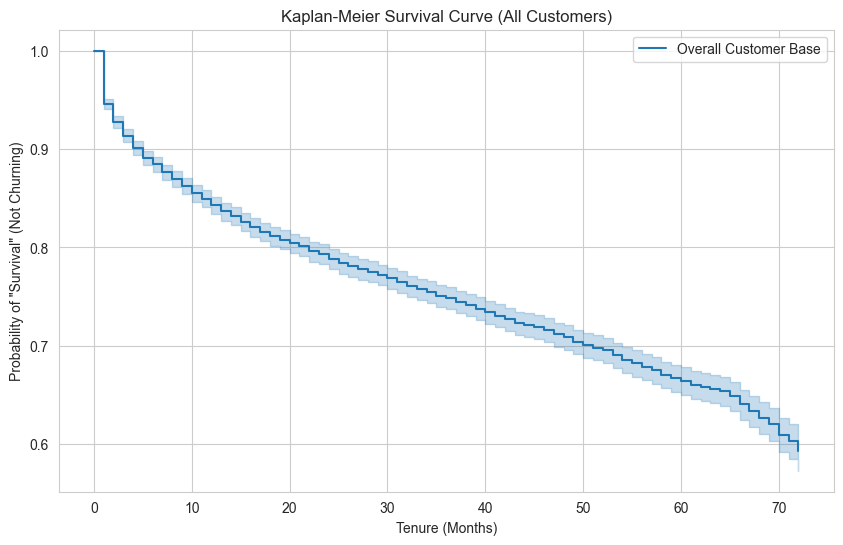


Training Cox Proportional Hazards Model...

An error occurred: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.


In [ ]:
# --- Week 6: Prognosis (Survival Analysis / Time-to-Churn) ---

!pip install lifelines

import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import CoxPHFitter, KaplanMeierFitter
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print("\n--- Week 6: Prognosis (Survival Analysis) ---")

try:
    if 'df_class_processed' not in locals():
        print("Error: 'df_class_processed' not found. Please run Cell 1 (Week 4) first.")
        
    
    df_cox = df_class_processed.copy()
    
    df_cox['tenure'] = df.loc[df_class_processed.index, 'tenure']
    
    if 'TotalCharges' in df_cox.columns:
        df_cox = df_cox.drop('TotalCharges', axis=1)

    print("Plotting overall survival curve...")
    T = df_cox['tenure']
    E = df_cox['Churn']
    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=E, label="Overall Customer Base")

    plt.figure(figsize=(10, 6))
    kmf.plot_survival_function()
    plt.title('Kaplan-Meier Survival Curve (All Customers)')
    plt.xlabel('Tenure (Months)')
    plt.ylabel('Probability of "Survival" (Not Churning)')
    plt.grid(True)
    plt.show()

    print("\nTraining Cox Proportional Hazards Model...")
    
    cph = CoxPHFitter()
    cph.fit(df_cox, duration_col='tenure', event_col='Churn')
    
    print("\nCoxPH Model Summary (Factors influencing *when* churn happens):")
    cph.print_summary(columns=['exp(coef)', 'p'])
    
    print("\nPlotting feature impacts (Hazard Ratios)...")
    plt.figure(figsize=(12, 9))
    cph.plot()
    plt.title('CoxPH Model - Feature Impact on Churn Hazard')
    plt.tight_layout()
    plt.show()

except NameError as e:
    print(f"\nError: A required variable is missing: {e}")
    print("Please run Cell 1 (Week 4) first to create the necessary DataFrames.")
except Exception as e:
    print(f"\nAn error occurred: {e}")

# Week 9 - "Dynamic Pricing"
I4.0 Concept: Adjusting prices based on real-time data.

Telco Analogy: We can't build a real-time model, but we can do the core analysis needed for one: Price Sensitivity Analysis. We will see how MonthlyCharges (price) affects the churn rate for different groups. This tells you which customers are most sensitive to price.


--- Week 9: Price Sensitivity Analysis ---

Churn Rate by Monthly Charge Bracket:
         PriceBin  ChurnRate
0    (17.0, 20.0]   0.085434
1    (20.0, 25.0]   0.098291
2    (25.0, 46.0]   0.253582
3    (46.0, 59.0]   0.246066
4    (59.0, 70.0]   0.216714
5    (70.0, 79.0]   0.382228
6    (79.0, 86.0]   0.378963
7    (86.0, 94.0]   0.340845
8   (94.0, 103.0]   0.412356
9  (103.0, 119.0]   0.247159


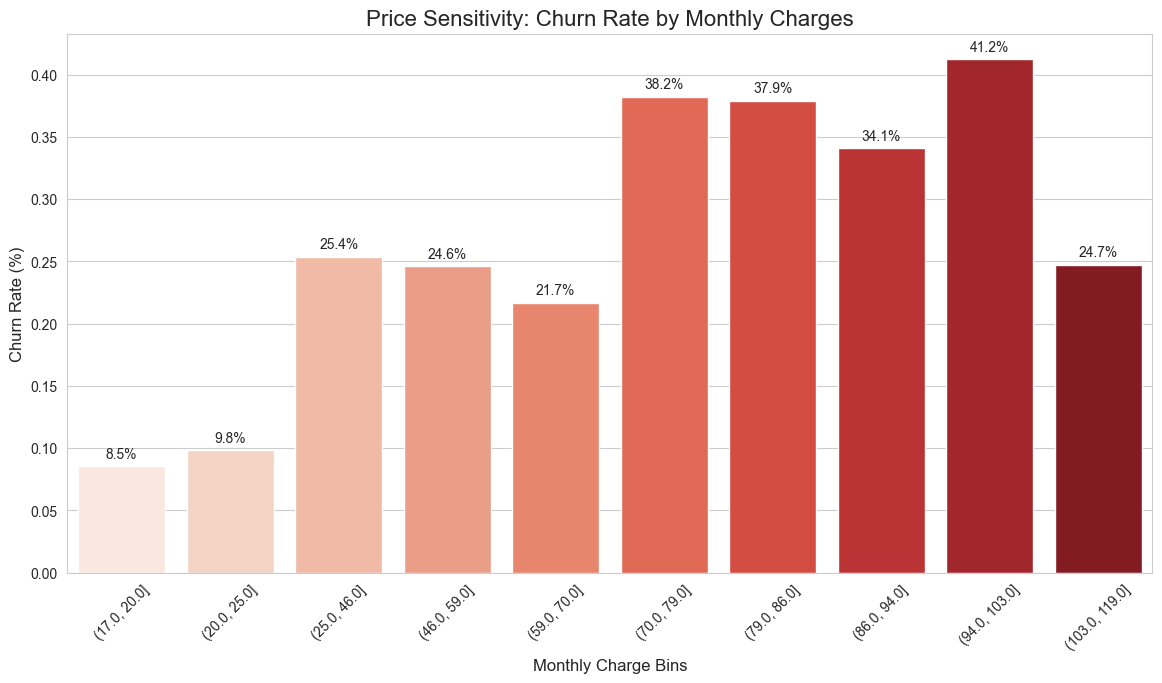


Analysis: This plot shows how sensitive customers are to price.
A company could use this to create targeted discounts (dynamic prices) for
the most price-sensitive brackets (those with the highest churn).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

print("\n--- Week 9: Price Sensitivity Analysis ---")

try:
    if "df" not in locals():
        print("Loading and preprocessing data...")
        df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
        df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
        df.dropna(subset=["TotalCharges"], inplace=True)

    df["PriceBin"] = pd.qcut(df["MonthlyCharges"], q=10, precision=0)

    df["Churn_numeric"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

    price_sensitivity = df.groupby("PriceBin")["Churn_numeric"].mean().reset_index()
    price_sensitivity.rename(columns={"Churn_numeric": "ChurnRate"}, inplace=True)

    print("\nChurn Rate by Monthly Charge Bracket:")
    print(price_sensitivity)

    plt.figure(figsize=(14, 7))
    ax = sns.barplot(
        x="PriceBin", y="ChurnRate", data=price_sensitivity, palette="Reds"
    )
    plt.title("Price Sensitivity: Churn Rate by Monthly Charges", fontsize=16)
    plt.xlabel("Monthly Charge Bins", fontsize=12)
    plt.ylabel("Churn Rate (%)", fontsize=12)
    plt.xticks(rotation=45)

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height() * 100:.1f}%",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
        )

    plt.show()

    print("\nAnalysis: This plot shows how sensitive customers are to price.")
    print("A company could use this to create targeted discounts (dynamic prices) for")
    print("the most price-sensitive brackets (those with the highest churn).")

except NameError:
    print("\nError: 'df' not found. Please run your initial data loading cell first.")

# Week 8/10 - "Inventory Optimization" / "Logistics 4.0"
I4.0 Concept: Managing physical inventory or logistics.

Telco Analogy: A Telco's "inventory" is its set of services. "Optimizing" this inventory means understanding which services are most valuable and which should be "bundled" (like items in a shipment). We can use Association Rule Mining (Market Basket Analysis) to find these bundles.

In [ ]:
!pip install mlxtend

import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import warnings

warnings.filterwarnings('ignore')

print("\n--- Week 8/10: Association Rule Mining (Service Bundles) ---")

try:
    if 'df' not in locals():
        print("Loading and preprocessing data...")
        df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df.dropna(subset=['TotalCharges'], inplace=True)

    service_cols = [
        'PhoneService', 'MultipleLines', 'InternetService', 
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    df_market = df[service_cols]

    df_basket = pd.DataFrame(index=df_market.index)
    df_basket['PhoneService'] = (df_market['PhoneService'] == 'Yes')
    df_basket['MultipleLines'] = (df_market['MultipleLines'] == 'Yes')
    df_basket['Internet_DSL'] = (df_market['InternetService'] == 'DSL')
    df_basket['Internet_Fiber'] = (df_market['InternetService'] == 'Fiber optic')
    df_basket['OnlineSecurity'] = (df_market['OnlineSecurity'] == 'Yes')
    df_basket['OnlineBackup'] = (df_market['OnlineBackup'] == 'Yes')
    df_basket['DeviceProtection'] = (df_market['DeviceProtection'] == 'Yes')
    df_basket['TechSupport'] = (df_market['TechSupport'] == 'Yes')
    df_basket['StreamingTV'] = (df_market['StreamingTV'] == 'Yes')
    df_basket['StreamingMovies'] = (df_market['StreamingMovies'] == 'Yes')
    
    df_basket = df_basket[df_basket.sum(axis=1) > 0]

    print(f"Basket data prepared for {len(df_basket)} customers.")

    print("Running Apriori to find frequent itemsets (min_support=0.1)...")
    frequent_itemsets = apriori(df_basket, min_support=0.1, use_colnames=True)

    print("Generating association rules (min_confidence=0.5)...")
    rules = association_rules(
        frequent_itemsets, 
        metric="confidence", 
        min_threshold=0.5
    )
    
    rules = rules[rules['lift'] > 1].sort_values(by='lift', ascending=False)
    
    print("\n--- Top Association Rules (Service Bundles) ---")
    if rules.empty:
        print("No strong rules found with these settings.")
    else:
        print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
        
    print("\nAnalysis: This shows which services ('inventory') are bought together.")
    print("e.g., 'If a customer buys (StreamingTV), they are also likely to buy (StreamingMovies)'.")
    print("A company uses this to optimize its 'inventory' by creating smart bundles.")

except NameError:
    print("\nError: 'df' not found. Please run your initial data loading cell first.")

Defaulting to user installation because normal site-packages is not writeable

--- Week 8/10: Association Rule Mining (Service Bundles) ---
Basket data prepared for 7032 customers.
Running Apriori to find frequent itemsets (min_support=0.1)...
Generating association rules (min_confidence=0.5)...

--- Top Association Rules (Service Bundles) ---
                                           antecedents  \
537                   (MultipleLines, StreamingMovies)   
536      (DeviceProtection, StreamingTV, PhoneService)   
535  (PhoneService, StreamingMovies, DeviceProtection)   
539                       (MultipleLines, StreamingTV)   
459                     (TechSupport, StreamingMovies)   
460                         (TechSupport, StreamingTV)   
518      (StreamingMovies, OnlineBackup, PhoneService)   
519          (StreamingTV, OnlineBackup, PhoneService)   
538                  (MultipleLines, DeviceProtection)   
499         (MultipleLines, StreamingTV, PhoneService)   

               


[notice] A new release of pip is available: 24.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
